In [45]:
  import numpy as np
  import matplotlib.pyplot as plt

  dataset = 20
  
  with np.load("data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

  with np.load("data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamsp = data["time_stamps"]  # acquisition times of the lidar scans
    
  with np.load("data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements
  
  with np.load("data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

  

In [46]:
old_yaw_rate = imu_angular_velocity[2]

FR = encoder_counts[0]
FL = encoder_counts[1]
RR = encoder_counts[2]
RL = encoder_counts[3]
print (len(FR))
# Create an array of indices for the new length (4956)
new_indices = np.linspace(0, len(old_yaw_rate) - 1, len(FR))
# Interpolate yaw_rate to match the length of FR
yaw_rate = np.interp(new_indices, np.arange(len(old_yaw_rate)), old_yaw_rate)

print (len(old_yaw_rate))
print (len(yaw_rate))

4956
12187
4956


In [47]:
# Constants from RobotConfiguration.pdf
WHEEL_DIAMETER = 0.254  # meters
COUNTS_PER_REV = 360
METERS_PER_TICK = WHEEL_DIAMETER * np.pi / COUNTS_PER_REV
ROBOT_WIDTH = 0.5842  # meters
ROBOT_LENGTH = 0.46355  # meters

# Function to calculate odometry from encoder data
def calculate_odometry(FR, FL, RR, RL, yaw_rate, dt):
    """
    Calculate robot's linear and angular velocity from encoder counts and IMU yaw rate.
    :param encoder_counts: [FR, FL, RR, RL] encoder counts
    :param yaw_rate: IMU yaw rate (rad/s)
    :param dt: time step (s)
    :return: linear velocity (m/s), angular velocity (rad/s)
    """
    # Calculate distance traveled by left and right wheels
    left_distance = (FL + RL) / 2 * METERS_PER_TICK
    right_distance = (FR + RR) / 2 * METERS_PER_TICK

    # Linear and angular velocity
    v = (left_distance + right_distance) / (2 * dt)
    omega = yaw_rate

    return v, omega

# Function to update robot pose using differential-drive motion model
def update_pose(pose, v, omega, dt):
    """
    Update robot's pose using differential-drive motion model.
    :param pose: current pose [x, y, theta]
    :param v: linear velocity (m/s)
    :param omega: angular velocity (rad/s)
    :param dt: time step (s)
    :return: updated pose [x, y, theta]
    """
    x, y, theta = pose
    x += v / omega * (np.sin(theta + omega * dt) - np.sin(theta))
    y += -v / omega * (np.cos(theta + omega * dt) - np.cos(theta))
    theta += omega * dt

    return np.array([x, y, theta])

In [48]:
poses = [np.array([0, 0, 0])]  # Start at origin

for i in range(1, len(FR)):
        dt = 0.025  # 40 Hz data
        v, omega = calculate_odometry(FL[i],RL[i],FR[i], RR[i], yaw_rate[i], dt)
        pose = update_pose(poses[-1], v, omega, dt)
        poses.append(pose)

In [76]:
poses = np.array(poses)
print (poses.shape)
#all_prev_scan = [poses.copy()] 
#all_curr_scan= [poses.copy()] 

(4956, 3)


In [81]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# LiDAR specifications
LIDAR_FOV = 270  # Field of view in degrees
LIDAR_RESOLUTION = 1081  # Number of range measurements per scan
LIDAR_MAX_RANGE = 30.0  # Maximum range in meters
lidar_range_min = 0.1  # Minimum range in meters
lidar_range_max = LIDAR_MAX_RANGE
lidar_angle_min = -LIDAR_FOV / 2 * np.pi / 180  # Minimum angle in radians
lidar_angle_max = LIDAR_FOV / 2 * np.pi / 180  # Maximum angle in radians

# Helper functions to convert between pose vectors and transformation matrices
def pose_to_matrix(pose):
    """
    Convert a pose vector [x, y, theta] to a 3x3 transformation matrix.
    """
    x, y, theta = pose
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta),  np.cos(theta), y],
        [0,             0,              1]
    ])

def matrix_to_pose(matrix):
    """
    Convert a 3x3 transformation matrix to a pose vector [x, y, theta].
    """
    x = matrix[0, 2]
    y = matrix[1, 2]
    theta = np.arctan2(matrix[1, 0], matrix[0, 0])
    return np.array([x, y, theta])

# Function to convert LiDAR ranges to Cartesian coordinates (sensor frame)
def range_to_cartesian(ranges, angles):
    """
    Convert LiDAR range measurements to Cartesian coordinates (x, y) in the sensor frame.
    :param ranges: LiDAR range measurements (Nx1 array).
    :param angles: Corresponding angles for each range measurement (Nx1 array).
    :return: Cartesian coordinates (Nx2 array).
    """
    # Filter out invalid range measurements
    valid_indices = (ranges >= lidar_range_min) & (ranges <= lidar_range_max)
    ranges = ranges[valid_indices]
    angles = angles[valid_indices]

    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    return np.vstack((x, y)).T

def icp(source, target, initial_pose, max_iterations=100, tolerance=1e-5):
    """
    Perform ICP to align the source point cloud to the target point cloud.
    
    :param source: Source point cloud (Nx2 array).
    :param target: Target point cloud (Mx2 array).
    :param initial_pose: Initial guess for the relative pose [dx, dy, dtheta].
    :param max_iterations: Maximum number of iterations.
    :param tolerance: Convergence threshold.
    :return: Refined relative pose [dx, dy, dtheta].
    """
    # Initialize global transformation with the initial guess
    transformation = pose_to_matrix(initial_pose)
    
    # Transform the source points with the initial guess
    source = (transformation[:2, :2] @ source.T).T + transformation[:2, 2]
    
    prev_error = np.inf

    for i in range(max_iterations):
        # Build a KDTree on target and find nearest neighbors for each source point
        kdtree = KDTree(target)
        distances, indices = kdtree.query(source)
        mean_error = np.mean(distances)
        
        # Check convergence based on error change
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

        # Get corresponding target points
        target_corr = target[indices]

        # Compute centroids
        centroid_source = np.mean(source, axis=0)
        centroid_target = np.mean(target_corr, axis=0)
        
        # Subtract centroids to get zero-mean point sets
        src_centered = source - centroid_source
        tgt_centered = target_corr - centroid_target
        
        # Compute cross-covariance matrix
        H = src_centered.T @ tgt_centered
        
        # Compute SVD of covariance matrix
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        
        # Ensure proper rotation (determinant = 1)
        if np.linalg.det(R) < 0:
            Vt[1, :] *= -1
            R = Vt.T @ U.T

        # Compute translation
        t = centroid_target - R @ centroid_source

        # Build the incremental transformation update
        T_update = np.eye(3)
        T_update[:2, :2] = R
        T_update[:2, 2] = t

        # Accumulate the transformation (left-multiply the update)
        transformation = T_update @ transformation

        # Update the source points for the next iteration
        source = (R @ source.T).T + t

    # Extract the refined pose from the cumulative transformation
    refined_t = transformation[:2, 2]
    refined_R = transformation[:2, :2]
    refined_dtheta = np.arctan2(refined_R[1, 0], refined_R[0, 0])
    return refined_t[0], refined_t[1], refined_dtheta

def scan_matching(prev_ranges, curr_ranges, initial_pose, angles):
    """
    Perform scan matching using ICP to estimate the relative pose between two LiDAR scans.
    
    :param prev_ranges: Previous LiDAR scan ranges (Nx1 array).
    :param curr_ranges: Current LiDAR scan ranges (Nx1 array).
    :param initial_pose: Initial guess for relative pose [dx, dy, dtheta].
    :param angles: Angles corresponding to each LiDAR measurement.
    :return: Refined relative pose [dx, dy, dtheta].
    """
    # Convert ranges to Cartesian coordinates
    prev_scan = range_to_cartesian(prev_ranges, angles)
    curr_scan = range_to_cartesian(curr_ranges, angles)
    
    # (Optional) Store scans for visualization later if needed
    all_prev_scan.append(prev_scan)
    all_curr_scan.append(curr_scan)

    # Run ICP
    refined_pose = icp(curr_scan, prev_scan, initial_pose)
    return refined_pose

def update_robot_pose(pose, relative_pose):
    """
    Update the robot's pose using the relative pose change.
    
    :param pose: Current robot pose [x, y, theta].
    :param relative_pose: Relative pose change [dx, dy, dtheta].
    :return: Updated robot pose [x, y, theta].
    """
    T = pose_to_matrix(pose)
    T_relative = pose_to_matrix(relative_pose)
    T_new = T @ T_relative  # Note: right-multiply the relative update
    return matrix_to_pose(T_new)

# --- Main scan-matching loop ---

# (Assume lidar_ranges is provided as a 2D array: each column is one scan of size LIDAR_RESOLUTION)
# For example, you might load lidar_ranges from your sensor data.
# Here we assume lidar_ranges is defined elsewhere in your code.

# Generate angles for LiDAR scans
angles = np.linspace(lidar_angle_min, lidar_angle_max, LIDAR_RESOLUTION)

# Initialize robot pose [x, y, theta]
robot_pose = np.array([0.0, 0.0, 0.0])
initial_pose = robot_pose.copy()  # initial relative pose guess for the first scan match

# Lists to store the robot pose over time
all_poses = [robot_pose.copy()]

# (Optional) Lists to store scans for visualization
all_prev_scan = []
all_curr_scan = []

# Iterate over all LiDAR scans (assuming lidar_ranges is a 2D array where each column is one scan)
num_scans = lidar_ranges.shape[1]
for i in range(num_scans - 1):
    prev_ranges = lidar_ranges[:, i]    # Previous scan (1081 measurements)
    curr_ranges = lidar_ranges[:, i+1]    # Current scan (1081 measurements)

    # Run scan matching using ICP; you can use the previous relative pose as an initial guess.
    relative_pose = scan_matching(prev_ranges, curr_ranges, initial_pose, angles)

    # Update the robot pose using the estimated relative transformation
    robot_pose = update_robot_pose(robot_pose, relative_pose)
    all_poses.append(robot_pose.copy())

    # For the next iteration, you might choose to use the estimated relative pose as the new initial guess.
    initial_pose = relative_pose  

    print(f"Iteration {i}: relative_pose = {relative_pose}, robot_pose = {robot_pose}")

all_poses = np.array(all_poses)

# Print final results
print("Number of poses:", len(all_poses))
print("Initial Pose:", all_poses[0])
print("Final Pose:", all_poses[-1])
print("All Poses Shape:", all_poses.shape)


Iteration 0: relative_pose = (0.0007262391326464276, 0.0005910345868829338, -0.0001370302892582788), robot_pose = [ 0.00072624  0.00059103 -0.00013703]
Iteration 1: relative_pose = (-0.00018923492836211113, -0.0003014299487634517, 6.232634008029971e-05), robot_pose = [ 5.36962901e-04  2.89630572e-04 -7.47039492e-05]
Iteration 2: relative_pose = (-0.00012901245936925275, -0.00013743839836006914, -0.00012211048097356554), robot_pose = [ 0.00040794  0.0001522  -0.00019681]
Iteration 3: relative_pose = (0.00041460308119338317, 0.00011933006878133455, -2.703713023418993e-05), robot_pose = [ 0.00082257  0.00027145 -0.00022385]
Iteration 4: relative_pose = (-1.006741604769226e-05, 6.167928176337852e-05, -4.5071270418412805e-06), robot_pose = [ 0.00081251  0.00033313 -0.00022836]
Iteration 5: relative_pose = (0.0008440028371279152, 0.00035599926135152025, -5.789815736502879e-05), robot_pose = [ 0.0016566   0.00068894 -0.00028626]
Iteration 6: relative_pose = (-0.0006184137370915114, -0.0001492

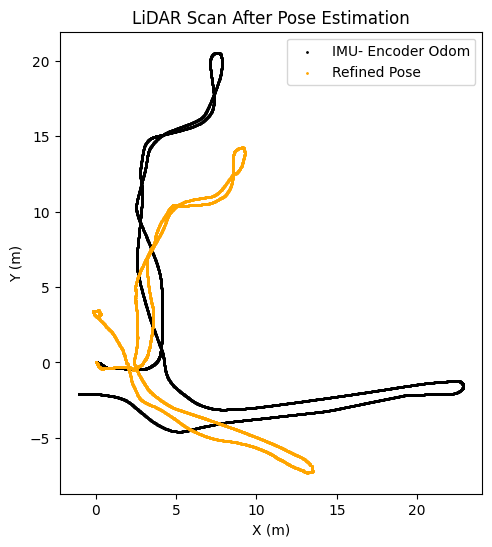

In [74]:
# Plotting the LiDAR scans before and after pose estimation
plt.figure(figsize=(12, 6))


# Plot the last scan (after pose estimation)
plt.subplot(1, 2, 2)
plt.scatter(poses[:, 0], poses[:, 1], s=1, c='black', label='IMU- Encoder Odom')
plt.scatter(all_poses[:, 0], all_poses[:, 1], s=1, c='orange', label='Refined Pose')
plt.title('LiDAR Scan After Pose Estimation')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()

plt.show()

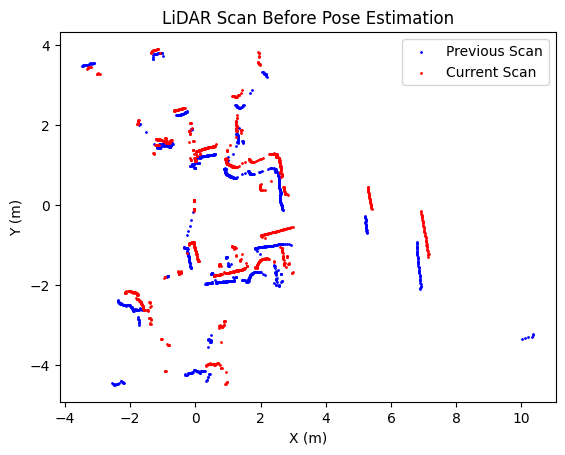

In [93]:
# Plot the first scan (before pose estimation)

plt.scatter(all_prev_scan[0][:, 0], all_prev_scan[0][:, 1], s=1, c='blue', label='Previous Scan')
plt.scatter(all_curr_scan[-1][:, 0], all_curr_scan[-1][:, 1], s=1, c='red', label='Current Scan')
plt.title('LiDAR Scan Before Pose Estimation')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()


In [55]:
import os
import numpy as np
import cv2

# Function to load RGB and disparity images from folders
def load_rgb_and_disparity_images(dataset):
    """
    Load RGB and disparity images from the specified dataset folder.
    :param dataset: dataset number (e.g., 20)
    :return: rgb_images, disparity_images, rgb_stamps, disparity_stamps
    """
    # Load timestamps
    with np.load(f"data/Kinect{dataset}.npz") as data:
        rgb_stamps = data["rgb_time_stamps"]
        disparity_stamps = data["disparity_time_stamps"]

    # Load RGB images
    rgb_folder = f"data/RGB{dataset}"
    rgb_images = []
    for filename in sorted(os.listdir(rgb_folder)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(rgb_folder, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            rgb_images.append(img)

    # Load disparity images
    disparity_folder = f"data/Disparity{dataset}"
    disparity_images = []
    for filename in sorted(os.listdir(disparity_folder)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(disparity_folder, filename), cv2.IMREAD_GRAYSCALE)
            disparity_images.append(img)

    return rgb_images, disparity_images, rgb_stamps, disparity_stamps

# Load RGB and disparity images for the specified dataset
dataset = 20  # Replace with your dataset number
rgb_images, disparity_images, rgb_stamps, disparity_stamps = load_rgb_and_disparity_images(dataset)

# Print the number of images loaded
print(f"Loaded {len(rgb_images)} RGB images and {len(disparity_images)} disparity images.")

Loaded 2289 RGB images and 2407 disparity images.


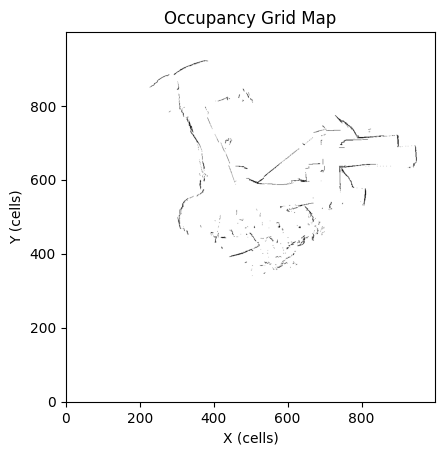

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for occupancy grid mapping
MAP_RESOLUTION = 0.05  # meters per cell
MAP_SIZE = 1000  # size of the map in cells (1000x1000)
OCCUPANCY_THRESHOLD = 0.5  # threshold for occupied cells
FREE_THRESHOLD = -0.5  # threshold for free cells
LOG_ODDS_OCCUPIED = 0.9  # log-odds value for occupied cells
LOG_ODDS_FREE = -0.7  # log-odds value for free cells

# Initialize the occupancy grid map
occupancy_grid = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.float32)

# Function to convert world coordinates to map coordinates
def world_to_map(x, y):
    """
    Convert world coordinates (x, y) to map coordinates.
    :param x: x-coordinate(s) in world frame (meters) - can be a scalar or array
    :param y: y-coordinate(s) in world frame (meters) - can be a scalar or array
    :return: (i, j) map coordinates as arrays
    """
    i = ((x / MAP_RESOLUTION) + MAP_SIZE // 2).astype(int)
    j = ((y / MAP_RESOLUTION) + MAP_SIZE // 2).astype(int)
    return i, j

# Function to update the occupancy grid map
def update_occupancy_grid(occupancy_grid, scan, pose):
    """
    Update the occupancy grid map with a LiDAR scan.
    :param occupancy_grid: current occupancy grid map
    :param scan: LiDAR scan in Cartesian coordinates (Nx2 array)
    :param pose: robot pose [x, y, theta]
    """
    x, y, theta = pose
    T = pose_to_matrix(pose)
    
    # Transform LiDAR points from sensor frame to world frame
    scan_world = (T[:2, :2] @ scan.T).T + T[:2, 2]
    
    # Iterate over each LiDAR point
    for point in scan_world:
        px, py = point
        i, j = world_to_map(px, py)
        
        # Skip points outside the map
        if i < 0 or i >= MAP_SIZE or j < 0 or j >= MAP_SIZE:
            continue
        
        # Update log-odds for occupied cells
        occupancy_grid[i, j] += LOG_ODDS_OCCUPIED
        
        # Use Bresenham's line algorithm to mark free cells along the line of sight
        robot_i, robot_j = world_to_map(x, y)
        for (ci, cj) in bresenham(robot_i, robot_j, i, j):
            if ci < 0 or ci >= MAP_SIZE or cj < 0 or cj >= MAP_SIZE:
                continue
            if (ci, cj) == (i, j):
                continue
            occupancy_grid[ci, cj] += LOG_ODDS_FREE

# Function to create a binary occupancy map
def create_binary_occupancy_map(occupancy_grid):
    """
    Create a binary occupancy map from the log-odds grid.
    :param occupancy_grid: log-odds occupancy grid
    :return: binary occupancy map (0: free, 1: occupied)
    """
    binary_map = np.zeros_like(occupancy_grid, dtype=np.uint8)
    binary_map[occupancy_grid > OCCUPANCY_THRESHOLD] = 1
    binary_map[occupancy_grid < FREE_THRESHOLD] = 0
    return binary_map

# Function to visualize the occupancy grid map
def visualize_occupancy_grid(occupancy_grid):
    """
    Visualize the occupancy grid map.
    :param occupancy_grid: occupancy grid map
    """
    binary_map = create_binary_occupancy_map(occupancy_grid)
    plt.imshow(binary_map, cmap='gray_r', origin='lower')
    plt.title("Occupancy Grid Map")
    plt.xlabel("X (cells)")
    plt.ylabel("Y (cells)")
    plt.show()

# --- Occupancy Grid Mapping ---

# Generate angles for LiDAR scans
angles = np.linspace(lidar_angle_min, lidar_angle_max, LIDAR_RESOLUTION)

# Initialize robot pose [x, y, theta]
robot_pose = np.array([0.0, 0.0, 0.0])

# Iterate over all LiDAR scans and update the occupancy grid
for i in range(len(all_poses)):
    pose = all_poses[i]
    ranges = lidar_ranges[:, i]
    
    # Convert LiDAR ranges to Cartesian coordinates
    scan = range_to_cartesian(ranges, angles)
    
    # Update the occupancy grid with the current scan
    update_occupancy_grid(occupancy_grid, scan, pose)

# Visualize the final occupancy grid map
visualize_occupancy_grid(occupancy_grid)

In [99]:
# Check RGB and disparity images
print("RGB Image Shape:", rgb_image.shape)
print("Disparity Image Shape:", disparity_image.shape)
print("Disparity Min:", np.min(disparity_image))
print("Disparity Max:", np.max(disparity_image))
# Check depth values
depth = 1.03 / (-0.00304 * disparity_image + 3.31)
print("Depth Min:", np.min(depth))
print("Depth Max:", np.max(depth))
# Check projected points
points_world = project_rgbd_to_world(rgb_image, disparity_image, pose)
print("Projected Points Shape:", points_world.shape)
print("Projected Points (First 5):", points_world[:5])
# Check texture map update
texture_map = create_texture_map_optimized(occupancy_grid, colored_points_filtered)
print("Texture Map Min:", np.min(texture_map))
print("Texture Map Max:", np.max(texture_map))

RGB Image Shape: (480, 640, 3)
Disparity Image Shape: (480, 640)
Disparity Min: 2
Disparity Max: 7
Depth Min: 0.3117508898520545
Depth Max: 0.3131917584957065
Projected Points Shape: (307200, 3)
Projected Points (First 5): [[  3.3779864    7.79032755  98.33333333]
 [  3.37780792   7.78982495  99.        ]
 [  3.37762944   7.78932234 100.        ]
 [  3.37745097   7.78881974 102.        ]
 [  3.37727249   7.78831713  99.33333333]]
Texture Map Min: 0
Texture Map Max: 0


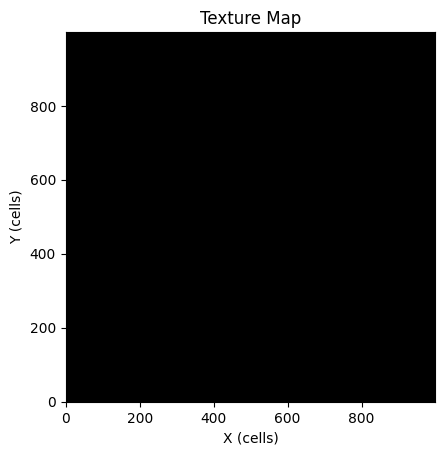

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to downsample an image
def downsample_image(image, scale_factor=0.25):
    """
    Downsample an image by a given scale factor.
    :param image: input image (HxW or HxWx3)
    :param scale_factor: scaling factor (e.g., 0.25 for 1/4 resolution)
    :return: downsampled image
    """
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Function to filter points based on depth
def filter_points_by_depth(points, depth_min=0.5, depth_max=5.0):
    """
    Filter points based on depth values.
    :param points: colored points in world frame (Nx3 array: x, y, color)
    :param depth_min: minimum depth value (meters)
    :param depth_max: maximum depth value (meters)
    :return: filtered points (Mx3 array, where M <= N)
    """
    # Calculate depth (z-coordinate) for each point
    depth = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
    
    # Filter points based on depth
    valid_indices = (depth >= depth_min) & (depth <= depth_max)
    return points[valid_indices]

# Function to project RGBD points to the world frame
# Fix RGBD point projection
def project_rgbd_to_world(rgb_image, disparity_image, pose):
    # Convert disparity to depth
    valid_disparity = (disparity_image > 0) & (disparity_image < 255)
    depth = np.zeros_like(disparity_image, dtype=np.float32)
    depth[valid_disparity] = 1.03 / (-0.00304 * disparity_image[valid_disparity] + 3.31)

    # Get pixel coordinates
    rows, cols = np.indices(depth.shape)
    rgb_i = (526.37 * cols + 19276 - 7877.07 * depth) / 585.051
    rgb_j = (526.37 * rows + 16662) / 585.051

    # Get RGB values
    rgb_i = np.clip(rgb_i, 0, rgb_image.shape[1] - 1).astype(int)
    rgb_j = np.clip(rgb_j, 0, rgb_image.shape[0] - 1).astype(int)
    colors = rgb_image[rgb_j, rgb_i]

    # Convert depth to 3D points in the camera frame
    fx = 585.05
    fy = 585.05
    cx = 242.94
    cy = 315.84
    z = depth
    x = (cols - cx) * z / fx
    y = (rows - cy) * z / fy

    # Transform points to the world frame
    T = pose_to_matrix(pose)
    points_camera = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    points_world = (T[:2, :2] @ points_camera[:2, :]).T + T[:2, 2]

    # Combine with colors
    colored_points = np.hstack((points_world, colors.reshape(-1, 3)))
    return colored_points

# Fix texture map update
def create_texture_map_optimized(occupancy_grid, colored_points):
    texture_map = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)
    
    # Convert world coordinates to map coordinates
    i, j = world_to_map(colored_points[:, 0], colored_points[:, 1])
    
    # Filter out points outside the map
    valid_indices = (i >= 0) & (i < MAP_SIZE) & (j >= 0) & (j < MAP_SIZE)
    i = i[valid_indices]
    j = j[valid_indices]
    colors = colored_points[valid_indices, 2:].astype(np.uint8)
    
    # Update the texture map in batches
    texture_map[i, j] = colors
    
    return texture_map

# Function to downsample an image
def downsample_image(image, scale_factor=0.25):
    """
    Downsample an image by a given scale factor.
    :param image: input image (HxW or HxWx3)
    :param scale_factor: scaling factor (e.g., 0.25 for 1/4 resolution)
    :return: downsampled image
    """
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Function to filter points based on depth
def filter_points_by_depth(points, depth_min=0.5, depth_max=5.0):
    """
    Filter points based on depth values.
    :param points: colored points in world frame (Nx3 array: x, y, color)
    :param depth_min: minimum depth value (meters)
    :param depth_max: maximum depth value (meters)
    :return: filtered points (Mx3 array, where M <= N)
    """
    # Calculate depth (z-coordinate) for each point
    depth = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
    
    # Filter points based on depth
    valid_indices = (depth >= depth_min) & (depth <= depth_max)
    return points[valid_indices]

# Function to project RGBD points to the world frame
def project_rgbd_to_world(rgb_image, disparity_image, pose):
    """
    Project RGBD points to the world frame using the robot's pose.
    :param rgb_image: RGB image (HxWx3)
    :param disparity_image: disparity image (HxW)
    :param pose: robot pose [x, y, theta]
    :return: colored points in world frame (Nx3 array: x, y, color)
    """
    # Convert disparity to depth
    depth = 1.03 / (-0.00304 * disparity_image + 3.31)
    
    # Get pixel coordinates
    rows, cols = np.indices(depth.shape)
    rgb_i = (526.37 * cols + 19276 - 7877.07 * depth) / 585.051
    rgb_j = (526.37 * rows + 16662) / 585.051
    
    # Get RGB values
    rgb_i = np.clip(rgb_i, 0, rgb_image.shape[1] - 1).astype(int)
    rgb_j = np.clip(rgb_j, 0, rgb_image.shape[0] - 1).astype(int)
    colors = rgb_image[rgb_j, rgb_i]
    
    # Convert depth to 3D points in the camera frame
    fx = 585.05
    fy = 585.05
    cx = 242.94
    cy = 315.84
    z = depth
    x = (cols - cx) * z / fx
    y = (rows - cy) * z / fy
    
    # Transform points to the world frame
    T = pose_to_matrix(pose)
    points_camera = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    points_world = (T[:2, :2] @ points_camera[:2, :]).T + T[:2, 2]
    
    # Combine with colors
    colored_points = np.hstack((points_world, np.mean(colors.reshape(-1, 3), axis=1).reshape(-1, 1)))
    return colored_points

# Function to create a texture map (optimized)
def create_texture_map_optimized(occupancy_grid, colored_points):
    """
    Create a texture map from colored points (optimized version).
    :param occupancy_grid: occupancy grid map
    :param colored_points: colored points in world frame (Nx3 array: x, y, color)
    :return: texture map (same size as occupancy grid)
    """
    texture_map = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)
    
    # Convert world coordinates to map coordinates
    i, j = world_to_map(colored_points[:, 0], colored_points[:, 1])
    
    # Filter out points outside the map
    valid_indices = (i >= 0) & (i < MAP_SIZE) & (j >= 0) & (j < MAP_SIZE)
    i = i[valid_indices]
    j = j[valid_indices]
    colors = colored_points[valid_indices, 2:]
    
    # Update the texture map in batches
    texture_map[i, j] = colors
    
    return texture_map

# --- Texture Mapping ---

# --- Texture Mapping ---

# Initialize texture map
texture_map = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)

# Iterate over RGBD images and update the texture map
for i in range(len(rgb_images)):
    rgb_image = rgb_images[i]
    disparity_image = disparity_images[i]
    pose = all_poses[i]  # Use the corresponding pose from the trajectory
    
    # Downsample RGB and disparity images
    rgb_image_downsampled = downsample_image(rgb_image, scale_factor=0.25)
    disparity_image_downsampled = downsample_image(disparity_image, scale_factor=0.25)
    
    # Project RGBD points to the world frame
    colored_points = project_rgbd_to_world(rgb_image_downsampled, disparity_image_downsampled, pose)
    
    # Filter points based on depth
    colored_points_filtered = filter_points_by_depth(colored_points, depth_min=0.5, depth_max=5.0)
    
    # Update the texture map (optimized)
    texture_map = create_texture_map_optimized(occupancy_grid, colored_points_filtered)

# Visualize the texture map
plt.imshow(texture_map, origin='lower')
plt.title("Texture Map")
plt.xlabel("X (cells)")
plt.ylabel("Y (cells)")
plt.show()

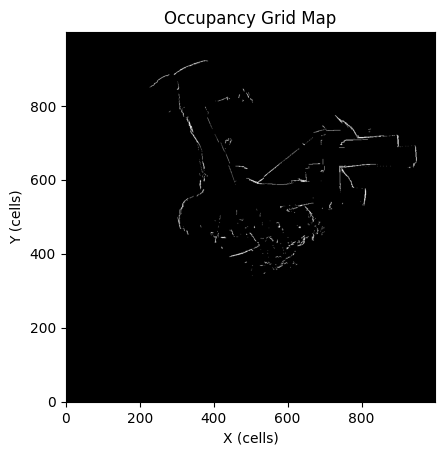

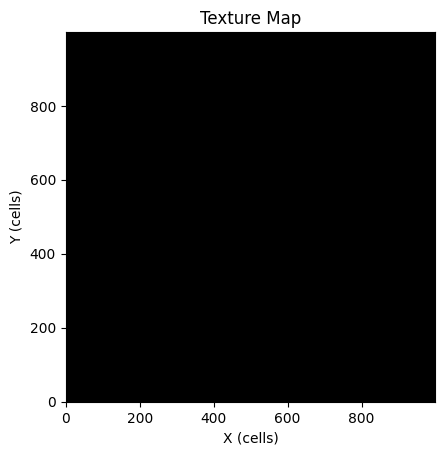

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Constants for occupancy grid mapping
MAP_RESOLUTION = 0.05  # meters per cell
MAP_SIZE = 1000  # size of the map in cells (1000x1000)
OCCUPANCY_THRESHOLD = 0.5  # threshold for occupied cells
FREE_THRESHOLD = -0.5  # threshold for free cells
LOG_ODDS_OCCUPIED = 0.9  # log-odds value for occupied cells
LOG_ODDS_FREE = -0.7  # log-odds value for free cells

# Initialize the occupancy grid map
occupancy_grid = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.float32)

# Function to convert world coordinates to map coordinates
def world_to_map(x, y):
    """
    Convert world coordinates (x, y) to map coordinates.
    :param x: x-coordinate(s) in world frame (meters) - can be a scalar or array
    :param y: y-coordinate(s) in world frame (meters) - can be a scalar or array
    :return: (i, j) map coordinates as arrays
    """
    i = ((x / MAP_RESOLUTION) + MAP_SIZE // 2).astype(int)
    j = ((y / MAP_RESOLUTION) + MAP_SIZE // 2).astype(int)
    return i, j

# Function to update the occupancy grid map
def update_occupancy_grid(occupancy_grid, scan, pose):
    """
    Update the occupancy grid map with a LiDAR scan.
    :param occupancy_grid: current occupancy grid map
    :param scan: LiDAR scan in Cartesian coordinates (Nx2 array)
    :param pose: robot pose [x, y, theta]
    """
    x, y, theta = pose
    T = pose_to_matrix(pose)
    
    # Transform LiDAR points from sensor frame to world frame
    scan_world = (T[:2, :2] @ scan.T).T + T[:2, 2]
    
    # Iterate over each LiDAR point
    for point in scan_world:
        px, py = point
        i, j = world_to_map(px, py)
        
        # Skip points outside the map
        if i < 0 or i >= MAP_SIZE or j < 0 or j >= MAP_SIZE:
            continue
        
        # Update log-odds for occupied cells
        occupancy_grid[i, j] += LOG_ODDS_OCCUPIED
        
        # Use Bresenham's line algorithm to mark free cells along the line of sight
        robot_i, robot_j = world_to_map(x, y)
        for (ci, cj) in bresenham(robot_i, robot_j, i, j):
            if ci < 0 or ci >= MAP_SIZE or cj < 0 or cj >= MAP_SIZE:
                continue
            if (ci, cj) == (i, j):
                continue
            occupancy_grid[ci, cj] += LOG_ODDS_FREE

# Function to create a binary occupancy map
def create_binary_occupancy_map(occupancy_grid):
    """
    Create a binary occupancy map from the log-odds grid.
    :param occupancy_grid: log-odds occupancy grid
    :return: binary occupancy map (0: free, 1: occupied)
    """
    binary_map = np.zeros_like(occupancy_grid, dtype=np.uint8)
    binary_map[occupancy_grid > OCCUPANCY_THRESHOLD] = 1
    binary_map[occupancy_grid < FREE_THRESHOLD] = 0
    return binary_map

# Function to visualize the occupancy grid map
def visualize_occupancy_grid(occupancy_grid):
    """
    Visualize the occupancy grid map.
    :param occupancy_grid: occupancy grid map
    """
    binary_map = create_binary_occupancy_map(occupancy_grid)
    plt.imshow(binary_map, cmap='gray_r', origin='lower')
    plt.title("Occupancy Grid Map")
    plt.xlabel("X (cells)")
    plt.ylabel("Y (cells)")
    plt.show()

# --- Occupancy Grid Mapping ---

# Generate angles for LiDAR scans
angles = np.linspace(lidar_angle_min, lidar_angle_max, LIDAR_RESOLUTION)

# Initialize robot pose [x, y, theta]
robot_pose = np.array([0.0, 0.0, 0.0])

# Iterate over all LiDAR scans and update the occupancy grid
for i in range(len(all_poses)):
    pose = all_poses[i]
    ranges = lidar_ranges[:, i]
    
    # Convert LiDAR ranges to Cartesian coordinates
    scan = range_to_cartesian(ranges, angles)
    
    # Update the occupancy grid with the current scan
    update_occupancy_grid(occupancy_grid, scan, pose)

# Visualize the final occupancy grid map
visualize_occupancy_grid(occupancy_grid)

# --- Texture Mapping ---

# Function to downsample an image
def downsample_image(image, scale_factor=0.25):
    """
    Downsample an image by a given scale factor.
    :param image: input image (HxW or HxWx3)
    :param scale_factor: scaling factor (e.g., 0.25 for 1/4 resolution)
    :return: downsampled image
    """
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Function to filter points based on depth
def filter_points_by_depth(points, depth_min=0.5, depth_max=5.0):
    """
    Filter points based on depth values.
    :param points: colored points in world frame (Nx3 array: x, y, color)
    :param depth_min: minimum depth value (meters)
    :param depth_max: maximum depth value (meters)
    :return: filtered points (Mx3 array, where M <= N)
    """
    # Calculate depth (z-coordinate) for each point
    depth = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
    
    # Filter points based on depth
    valid_indices = (depth >= depth_min) & (depth <= depth_max)
    return points[valid_indices]

# Function to project RGBD points to the world frame
def project_rgbd_to_world(rgb_image, disparity_image, pose):
    """
    Project RGBD points to the world frame using the robot's pose.
    :param rgb_image: RGB image (HxWx3)
    :param disparity_image: disparity image (HxW)
    :param pose: robot pose [x, y, theta]
    :return: colored points in world frame (Nx3 array: x, y, color)
    """
    # Convert disparity to depth
    depth = 1.03 / (-0.00304 * disparity_image + 3.31)
    
    # Get pixel coordinates
    rows, cols = np.indices(depth.shape)
    rgb_i = (526.37 * cols + 19276 - 7877.07 * depth) / 585.051
    rgb_j = (526.37 * rows + 16662) / 585.051
    
    # Get RGB values
    rgb_i = np.clip(rgb_i, 0, rgb_image.shape[1] - 1).astype(int)
    rgb_j = np.clip(rgb_j, 0, rgb_image.shape[0] - 1).astype(int)
    colors = rgb_image[rgb_j, rgb_i]
    
    # Convert depth to 3D points in the camera frame
    fx = 585.05
    fy = 585.05
    cx = 242.94
    cy = 315.84
    z = depth
    x = (cols - cx) * z / fx
    y = (rows - cy) * z / fy
    
    # Transform points to the world frame
    T = pose_to_matrix(pose)
    points_camera = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    points_world = (T[:2, :2] @ points_camera[:2, :]).T + T[:2, 2]
    
    # Combine with colors
    colored_points = np.hstack((points_world, np.mean(colors.reshape(-1, 3), axis=1).reshape(-1, 1)))
    return colored_points

# Function to create a texture map (optimized)
def create_texture_map_optimized(occupancy_grid, colored_points):
    """
    Create a texture map from colored points (optimized version).
    :param occupancy_grid: occupancy grid map
    :param colored_points: colored points in world frame (Nx3 array: x, y, color)
    :return: texture map (same size as occupancy grid)
    """
    texture_map = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)
    
    # Convert world coordinates to map coordinates
    i, j = world_to_map(colored_points[:, 0], colored_points[:, 1])
    
    # Filter out points outside the map
    valid_indices = (i >= 0) & (i < MAP_SIZE) & (j >= 0) & (j < MAP_SIZE)
    i = i[valid_indices]
    j = j[valid_indices]
    colors = colored_points[valid_indices, 2:]
    
    # Update the texture map in batches
    texture_map[i, j] = colors
    
    return texture_map

# --- Texture Mapping ---

# Initialize texture map
texture_map = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)

# Iterate over RGBD images and update the texture map
for i in range(len(rgb_images)):
    rgb_image = rgb_images[i]
    disparity_image = disparity_images[i]
    pose = all_poses[i]  # Use the corresponding pose from the trajectory
    
    # Downsample RGB and disparity images
    rgb_image_downsampled = downsample_image(rgb_image, scale_factor=0.25)
    disparity_image_downsampled = downsample_image(disparity_image, scale_factor=0.25)
    
    # Project RGBD points to the world frame
    colored_points = project_rgbd_to_world(rgb_image_downsampled, disparity_image_downsampled, pose)
    
    # Filter points based on depth
    colored_points_filtered = filter_points_by_depth(colored_points, depth_min=0.5, depth_max=5.0)
    
    # Update the texture map (optimized)
    texture_map = create_texture_map_optimized(occupancy_grid, colored_points_filtered)

# Visualize the texture map
plt.imshow(texture_map, origin='lower')
plt.title("Texture Map")
plt.xlabel("X (cells)")
plt.ylabel("Y (cells)")
plt.show()

In [103]:
import gtsam
import numpy as np
def estimate_relative_pose_with_ICP(pose1, pose2):
    """
    Estimate the relative pose between two poses using ICP.
    :param pose1: First pose [x, y, theta]
    :param pose2: Second pose [x, y, theta]
    :return: Relative pose as a gtsam.Pose2 object
    """
    # Use ICP to estimate the relative pose
    # (Replace this with your ICP implementation)
    dx = pose2[0] - pose1[0]
    dy = pose2[1] - pose1[1]
    dtheta = pose2[2] - pose1[2]
    return gtsam.Pose2(dx, dy, dtheta)
# Constants
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.05]))  # Odometry noise model
LOOP_CLOSURE_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.05]))  # Loop closure noise model

# Initialize factor graph and values
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Add prior factor for the first pose
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.05]))
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(0, 0, 0), prior_noise))
initial_estimate.insert(0, gtsam.Pose2(0, 0, 0))

# Add odometry factors from ICP scan matching
for i in range(1, len(all_poses)):
    # Get relative pose from ICP
    relative_pose = gtsam.Pose2(all_poses[i][0] - all_poses[i-1][0],
                                all_poses[i][1] - all_poses[i-1][1],
                                all_poses[i][2] - all_poses[i-1][2])
    
    # Add odometry factor
    graph.add(gtsam.BetweenFactorPose2(i-1, i, relative_pose, ODOMETRY_NOISE))
    
    # Add initial estimate for the current pose
    initial_estimate.insert(i, gtsam.Pose2(all_poses[i][0], all_poses[i][1], all_poses[i][2]))

# Add loop closure factors (fixed-interval method)
loop_closure_interval = 10  # Add a loop closure every 10 poses
for i in range(loop_closure_interval, len(all_poses), loop_closure_interval):
    # Use ICP to estimate the relative pose between the current pose and a pose from earlier
    j = i - loop_closure_interval  # Pose to compare with
    relative_pose = estimate_relative_pose_with_ICP(all_poses[i], all_poses[j])
    
    # Add loop closure factor
    graph.add(gtsam.BetweenFactorPose2(j, i, relative_pose, LOOP_CLOSURE_NOISE))

# Optimize the factor graph
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

# Extract the optimized trajectory
optimized_trajectory = []
for i in range(len(all_poses)):
    pose = result.atPose2(i)
    optimized_trajectory.append([pose.x(), pose.y(), pose.theta()])

# Print the optimized trajectory
print("Optimized Trajectory:", optimized_trajectory)

# Plot the initial and optimized trajectories
plt.figure(figsize=(10, 6))
plt.plot([pose[0] for pose in all_poses], [pose[1] for pose in all_poses], label="Initial Trajectory", color="blue")
plt.plot([pose[0] for pose in optimized_trajectory], [pose[1] for pose in optimized_trajectory], label="Optimized Trajectory", color="red")
plt.title("Trajectory Before and After Optimization")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'gtsam'